In [7]:
import h5py

file_name = '../carbonara_compressed.h5'
f = h5py.File(file_name, 'r')

In [8]:
import numpy as np

def compute_features(embeddings):
    features = np.mean(embeddings, axis=0)
    features = np.concatenate((features, np.min(embeddings, axis=0)))
    features = np.concatenate((features, np.median(embeddings, axis=0)))
    features = np.concatenate((features, np.max(embeddings, axis=0)))
    features = np.concatenate((features, np.std(embeddings, axis=0)))
    features = np.concatenate((features, embeddings[0]))
    return np.concatenate((features, embeddings[-1]))


output_tm = np.array(f['output_tm'])
input = []
for i in range(19149):
    tmp = np.array(f[f"carbonara_z_{i}"])
    # tmp2 = np.array(f[f'carbonara_p_{i}'])
    # tmp = np.concatenate((tmp1, tmp2), axis=1)
    input.append(compute_features(tmp))
input = np.array(input)

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

X = torch.tensor(input, dtype=torch.float32)
y = torch.tensor(output_tm, dtype=torch.float32).unsqueeze(1)  # Make y 2D for PyTorch

# Create a dataset
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
def correlation(predictions, targets):# Flatten inputs to 1D tensors
    predictions = predictions.flatten()
    targets = targets.flatten()
    
    # Compute means
    pred_mean = predictions.mean()
    target_mean = targets.mean()
    
    # Compute covariance
    covariance = ((predictions - pred_mean) * (targets - target_mean)).mean()
    
    # Compute standard deviations
    pred_std = predictions.std()
    target_std = targets.std()
    
    # Compute Pearson correlation
    correlation = covariance / (pred_std * target_std + 1e-8)  # Add small epsilon to avoid division by zero
    
    return correlation

In [11]:
from scipy.stats import spearmanr

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),  # Input to hidden layer
            nn.ReLU(),  # Activation function
            nn.Linear(64, 32),  # Second hidden layer
            nn.ReLU(),
            nn.Linear(32, output_size)  # Output layer
        )
    
    def forward(self, x):
        return self.model(x)

# Instantiate the model
input_size = input.shape[1]
output_size = 1  # Single output (regression)
model = NeuralNetwork(input_size, output_size)

# Step 3: Define loss function and optimizer
loss_fn = nn.MSELoss()  # Mean squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

correlation_per_epoch = []
los_per_epoch = []

# Step 4: Train the model
epochs = 100
for epoch in range(epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Step 5: Validate the model
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)
            val_loss += loss.item()
            all_predictions.append(predictions)
            all_labels.append(batch_y)

    # Concatenate all predictions and true labels
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Compute the total loss on the entire validation dataset
    val_corr = spearmanr(all_predictions, all_labels).correlation
    correlation_per_epoch.append(val_corr)
    los_per_epoch.append(val_loss/len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Correlation: {val_corr:.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/100, Train Loss: 273.0844, Validation Correlation: 0.2975, Validation Loss: 225.2768
Epoch 2/100, Train Loss: 214.1616, Validation Correlation: 0.3360, Validation Loss: 240.4132
Epoch 3/100, Train Loss: 204.4764, Validation Correlation: 0.3538, Validation Loss: 206.1688
Epoch 4/100, Train Loss: 197.7042, Validation Correlation: 0.3708, Validation Loss: 202.5217
Epoch 5/100, Train Loss: 195.7910, Validation Correlation: 0.3819, Validation Loss: 199.7434
Epoch 6/100, Train Loss: 193.6782, Validation Correlation: 0.3891, Validation Loss: 198.7496
Epoch 7/100, Train Loss: 189.0466, Validation Correlation: 0.3850, Validation Loss: 215.9002
Epoch 8/100, Train Loss: 191.3564, Validation Correlation: 0.3967, Validation Loss: 202.7918
Epoch 9/100, Train Loss: 185.3695, Validation Correlation: 0.4000, Validation Loss: 194.0520
Epoch 10/100, Train Loss: 187.1337, Validation Correlation: 0.4017, Validation Loss: 240.9422
Epoch 11/100, Train Loss: 184.4849, Validation Correlation: 0.4064, V

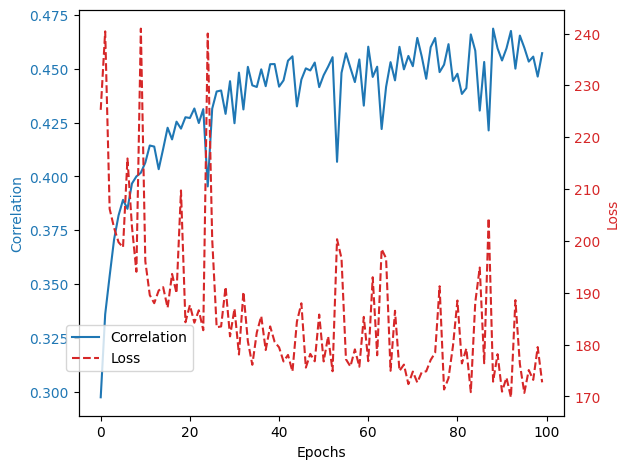

In [21]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Correlation', color='tab:blue')
ax1.plot(correlation_per_epoch, color='tab:blue', label='Correlation')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin axis for the second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')  # Second y-axis label
ax2.plot(los_per_epoch, color='tab:red', linestyle='--', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a legend (combining both axes)
fig.tight_layout()
fig.legend(loc="lower left", bbox_to_anchor=(0.1, 0.2))

# Show the plot
plt.show()

In [12]:
torch.save(model.state_dict(), "../model_weights/carbonara_simple.pth")